In [292]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import pandas as pd
import numpy as np 
from torch.utils.data import DataLoader, TensorDataset
from scipy.io import arff
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [361]:
X, y = make_classification(n_samples=1000, n_features=60,n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1], flip_y=0.1,  shuffle=True, random_state=1048)
y = torch.nn.functional.one_hot(torch.tensor(y.tolist()),2)

torch.Size([1000, 2])

In [294]:
d = np.bincount(y)
print(f'0:[{d[0]}], 1:[{d[1]}]')

0:[866], 1:[134]


In [295]:
train_x, train_y = torch.from_numpy(X[:700]), torch.from_numpy(y[:700])
val_x, val_y = torch.from_numpy(X[700:]), torch.from_numpy(y[700:])

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=300, shuffle=True)

In [296]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [297]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(60, 10)
        self.l2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.01)
        self.out = nn.Softmax()
        
    def forward(self, data):
        x = self.relu(self.l1(data))
        x = self.dropout(x)
        x = self.l2(x)
        x = self.out(x)
        return x


In [298]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [299]:
model = MyNN().to(device)

In [300]:
epochs = 20 
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

In [332]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float().to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 01: | Loss: 0.20063 | Acc: 93.000
Epoch 02: | Loss: 0.20158 | Acc: 92.818
Epoch 03: | Loss: 0.19992 | Acc: 92.545
Epoch 04: | Loss: 0.19943 | Acc: 92.909
Epoch 05: | Loss: 0.19845 | Acc: 92.727
Epoch 06: | Loss: 0.19929 | Acc: 92.909
Epoch 07: | Loss: 0.19603 | Acc: 93.182
Epoch 08: | Loss: 0.19890 | Acc: 93.000
Epoch 09: | Loss: 0.19693 | Acc: 93.273
Epoch 10: | Loss: 0.19522 | Acc: 93.091
Epoch 11: | Loss: 0.19707 | Acc: 93.273
Epoch 12: | Loss: 0.19560 | Acc: 92.636
Epoch 13: | Loss: 0.19445 | Acc: 93.000
Epoch 14: | Loss: 0.19404 | Acc: 93.455
Epoch 15: | Loss: 0.19598 | Acc: 93.273
Epoch 16: | Loss: 0.19470 | Acc: 93.455
Epoch 17: | Loss: 0.19392 | Acc: 93.182
Epoch 18: | Loss: 0.19429 | Acc: 93.091
Epoch 19: | Loss: 0.19326 | Acc: 93.182
Epoch 20: | Loss: 0.18987 | Acc: 93.273


              precision    recall  f1-score   support

           0       0.92      0.97      0.95       265
           1       0.63      0.34      0.44        35

    accuracy                           0.90       300
   macro avg       0.77      0.66      0.69       300
weighted avg       0.88      0.90      0.89       300



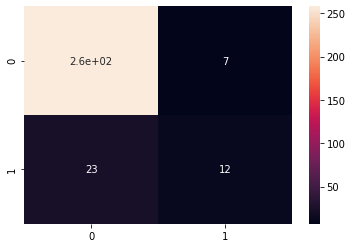

In [333]:
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        x = x.float().to(device)
        y_test_pred = model(x)
        pred = torch.round(y_test_pred)
        cf_matrix = confusion_matrix(y, pred.cpu().detach().numpy())
        print(classification_report(y, pred.cpu().detach().numpy()))
        sns.heatmap(cf_matrix, annot=True)

In [303]:
def CB_loss(labels, logits, samples_per_cls, no_of_classes, beta):

    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    # labels_one_hot = F.one_hot(labels, no_of_classes).float(

    weights = torch.tensor(weights).float()
    weights = weights.unsqueeze(0)
    new_weights = []
    for index in range(labels.shape[0]):
        new_weights.append(weights[0,labels[index].int()].item())

    labels = labels.unsqueeze(1).float()
    weights = new_weights #weights.repeat(labels_one_hot.shape[0],1)[labels_one_hot] * labels_one_hot
    weights = torch.from_numpy(np.array(weights)).to(device)
    # weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    # weights = weights.repeat(1,no_of_classes)
    cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels, weight = weights)
    return cb_loss.to(device)

In [304]:
output, inverse_indices = torch.unique(torch.tensor([[0,1,0,1,0,0,0,0,0]], dtype=torch.long), sorted=True, return_counts=True)
# ned to update things
print(output, inverse_indices)

tensor([0, 1]) tensor([7, 2])


In [336]:
model_1 = MyNN().to(device)
model_1.train()
for e in range(1, epochs+130):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float().to(device), y_batch.float().to(device)
        optimizer.zero_grad()

        y_pred = model_1(X_batch)

        # loss = criterion(y_pred, y_batch.unsqueeze(1))
        # CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma):
        output, samples_per_class = torch.unique(y_batch, sorted=True, return_counts=True)
        samples_per_class = samples_per_class.detach().cpu().numpy()
        loss = CB_loss(y_batch, y_pred,samples_per_class,2, 0.65)

        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()


    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 01: | Loss: 0.89332 | Acc: 40.273
Epoch 02: | Loss: 0.89495 | Acc: 39.727
Epoch 03: | Loss: 0.89506 | Acc: 41.091
Epoch 04: | Loss: 0.89788 | Acc: 40.364
Epoch 05: | Loss: 0.89922 | Acc: 40.000
Epoch 06: | Loss: 0.89513 | Acc: 40.636
Epoch 07: | Loss: 0.89735 | Acc: 40.818
Epoch 08: | Loss: 0.90072 | Acc: 40.000
Epoch 09: | Loss: 0.88795 | Acc: 40.636
Epoch 10: | Loss: 0.87894 | Acc: 40.273
Epoch 11: | Loss: 0.89845 | Acc: 40.727
Epoch 12: | Loss: 0.89788 | Acc: 40.273
Epoch 13: | Loss: 0.89870 | Acc: 40.455
Epoch 14: | Loss: 0.89744 | Acc: 41.364
Epoch 15: | Loss: 0.89598 | Acc: 40.182
Epoch 16: | Loss: 0.89170 | Acc: 40.727
Epoch 17: | Loss: 0.89566 | Acc: 41.091
Epoch 18: | Loss: 0.89325 | Acc: 40.364
Epoch 19: | Loss: 0.89733 | Acc: 40.545
Epoch 20: | Loss: 0.87237 | Acc: 40.364
Epoch 21: | Loss: 0.89153 | Acc: 40.091
Epoch 22: | Loss: 0.89293 | Acc: 39.909
Epoch 23: | Loss: 0.89858 | Acc: 40.727
Epoch 24: | Loss: 0.88795 | Acc: 40.455
Epoch 25: | Loss: 0.89032 | Acc: 41.000


              precision    recall  f1-score   support

           0       0.89      0.31      0.46       265
           1       0.12      0.71      0.21        35

    accuracy                           0.36       300
   macro avg       0.51      0.51      0.33       300
weighted avg       0.80      0.36      0.43       300



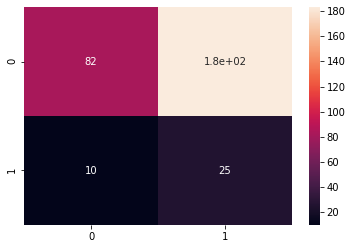

In [340]:

model_1.eval()
with torch.no_grad():
    for x,y in val_loader:
        x = x.float().to(device)
        y_test_pred = model_1(x)
        pred = torch.round(y_test_pred)
        cf_matrix = confusion_matrix(y, pred.cpu().detach().numpy())
        print(classification_report(y, pred.cpu().detach().numpy()))
        sns.heatmap(cf_matrix, annot=True)
